In [20]:
import pandas as pd
df=pd.read_csv('Data Complete.csv')
df=df.drop(columns=['Unnamed: 0'])

In [21]:
df['% Return']=df['Close'].pct_change()*100
df['Direction']=(df['% Return']>0).astype(int)
import numpy as np
df['Log Return']=np.log(df['Close']/df['Close'].shift(1))

In [22]:
df.columns

Index(['Date', 'Open', 'Close', 'Adj Close', 'High', 'Low', 'Volume',
       'MACD_Line', 'MACD_Signal', 'MACD_Histogram', 'RSI_14',
       'Daily % Return', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50',
       'EMA_50', 'SMA_100', 'EMA_100', 'SMA_200', 'EMA_200', 'Close_LAG1',
       'Close_LAG2', 'Close_LAG3', 'Close_LAG5', 'Close_LAG7', 'Close_LAG14',
       '% Return', 'Direction', 'Log Return'],
      dtype='object')

In [232]:
df_prophet=df[['Date','Adj Close']]
df_prophet.columns=['ds','y']
df_prophet['y']=np.log(df_prophet[['y']])

/var/folders/nc/hvlqvddd2xj11jl0l69nx3580000gn/T/ipykernel_42338/2860289521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prophet['y']=np.log(df_prophet[['y']])


In [233]:
from prophet import Prophet
p=Prophet()
p.fit(df_prophet)

19:43:34 - cmdstanpy - INFO - Chain [1] start processing
19:43:36 - cmdstanpy - INFO - Chain [1] done processing


In [234]:
prophet_forecast=p.predict(df_prophet[['ds']])
prophet_trend=prophet_forecast['trend'].values[:len(df_prophet)]

In [302]:
residuals=df_prophet['y'].values-prophet_trend

## Create lagged x and y for GRU on residuals

In [657]:
import numpy as np

def create_x_y(residual_series,n_lags):
    x,y=[],[]
    for i in range(len(residual_series)-n_lags):
        x.append(residual_series[i:i+n_lags])
        y.append(residual_series[i+n_lags])
    return np.array(x).reshape((-1,n_lags,1)),np.array(y)

n_lags=100
x_res,y_res=create_x_y(residuals,n_lags)

train_size=int(0.8*len(x_res))
past_n_days=100
x_train_res,x_test_res=x_res[:train_size],x_res[train_size:]
y_train_res,y_test_res=y_res[:train_size],y_res[train_size:]

In [663]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM

gru_res=Sequential([
    GRU(80,input_shape=(n_lags,1)),
    Dense(1)
])

gru_res.compile(loss='mean_squared_error',optimizer='adam')
gru_res.fit(x_train_res,y_train_res,epochs=50,validation_split=0.2,batch_size=32)

Epoch 1/50


/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0033 - val_loss: 4.0352e-04
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0014 - val_loss: 3.5114e-04
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0013 - val_loss: 4.2141e-04
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 9.8364e-04 - val_loss: 3.4582e-04
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0037 - val_loss: 3.0936e-04
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011 - val_loss: 3.4768e-04
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0014 - val_loss: 2.9769e-04
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012 - val_loss: 3.7111e-04
Epoch 9/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0030 - val_loss: 3.1989e-04
Epoch 10/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011 - val_loss: 3.1799e-04
Epoch 11/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0017 - val_loss: 3.0866e-04
Epoc

In [664]:
pred_res=gru_res.predict(x_test_res).flatten()

future=p.make_future_dataframe(periods=len(y_test_res))
prophet_forecast_gru=p.predict(future)
trend_test=prophet_forecast_gru['trend'].values[-len(y_test_res):]

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [665]:
trend_test,pred_res

(array([7.36243188, 7.36280411, 7.36317635, ..., 7.90924474, 7.90961698,
        7.90998921]),
 array([-0.0914484 , -0.09043772, -0.06955054, ..., -0.12904078,
        -0.1340464 , -0.14116815], dtype=float32))

In [666]:
trend_test=trend_test
pred_res=pred_res

In [667]:
hybrid_preds=0.91*(trend_test)+0.25*(pred_res)

In [668]:
hybrid_preds

array([6.67695091, 6.67754231, 6.68310284, ..., 7.16515252, 7.16423985,
       7.16279815])

In [669]:
y_true = df_prophet['y'].values[-len(y_test_res):]
y_true

array([6.46399032, 6.4866018 , 6.49478204, ..., 7.22460776, 7.21817684,
       7.22161663])

In [670]:
real=np.exp(y_true)
pred=np.exp(hybrid_preds)

In [676]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_true,hybrid_preds)*100

1.382405461712165

In [679]:
print("GRU+Prophet error % =",mean_absolute_percentage_error(real,pred)*100)

GRU+Prophet error % = 9.600557135102953


In [673]:
real,pred

(array([ 641.61621094,  656.28936768,  661.67999268, ..., 1372.80004883,
        1364.        , 1368.69995117]),
 array([ 793.89476084,  794.36441317,  798.79380293, ..., 1293.55887962,
        1292.37882151, 1290.51693908]))

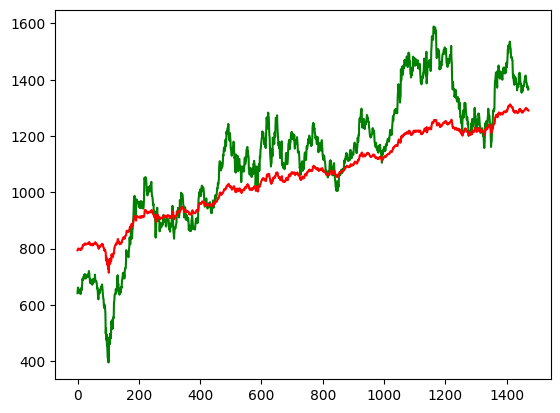

In [674]:
import matplotlib.pyplot as plt
plt.plot(real,'g')
plt.plot(pred,'r')